In [3]:
import cirq
from math import pi
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [5]:
def qc1(x):
    q0 = cirq.GridQubit(0, 0)
    q1 = cirq.GridQubit(0, 1)
    
    circuit = cirq.Circuit(
        cirq.rx(x).on(q0),
        cirq.CNOT(q0, q1),
        cirq.measure(q0, key='z0'),
        cirq.measure(q1, key='z1')
    )
    
    return circuit, ['z0', 'z1']

In [213]:
class Kernel:
    def __init__(self):
        self.weight = [255,255,255,255]
    
    def update_weight(self, w):
        self.weight = w
    
    def kernel1(self, P):
        # detects edge for weight (255,255,255)
        Q = [cirq.GridQubit(i,0) for i in range(4)]
        keys = ["q0", "q1", "q2", "q3"]

        circuit = cirq.Circuit()
        for i in range(4):
            circuit.append(cirq.ry((P[i] + self.weight[i])/255 *pi).on(Q[i]))

        for i in range(3):
            circuit.append(cirq.CNOT(Q[i],Q[i+1]))
        
        for i in range(4):
            circuit.append(cirq.measure(Q[i], key=keys[i]))
        
        return circuit, keys

    def kernel2(self, P):
        Q = [cirq.GridQubit(i,0) for i in range(4)]
        W = [cirq.GridQubit(i,1) for i in range(3)]
        keys = ["q0", "q1", "q2", "q3"]

        circuit = cirq.Circuit()
        # for i in range(4):
        #     circuit.append(cirq.H(Q[i]))

        for i in range(4):
            circuit.append(cirq.ry(P[i]/255 * pi).on(Q[i]))
        
        for i in range(3):
            circuit.append(cirq.rz(self.weight[i]/255 * pi).on(W[i]))
        
        for i in range(3):
            circuit.append(cirq.TOFFOLI(W[i], Q[i], Q[i+1]))

        for i in range(3):
            circuit.append(cirq.ZZ(Q[i], Q[i+1]))
        
        for i in range(4):
            circuit.append(cirq.measure(Q[i], key=keys[i]))
        return circuit, keys


    

In [208]:
def main(circuit, keys):
    # circuit = simple_quantum_circuit()
    print("Quantum Circuit:")
    print(circuit)

    # Use a simulator to run the quantum circuit
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=1000)

    # Print the measurement results
    print("\nMeasurement Results:")
    # print(result, type(result))
    for k in keys:
      print(k, ": ",result.histogram(key=k), (result.histogram(key=k)[1]))

In [214]:
circuit, keys = Kernel().kernel2([0,12,230,0])
main(circuit, keys)

Quantum Circuit:
(0, 0): ───Ry(0)────────@───────ZZ───M('q0')───────────────────────
                        │       │
(0, 1): ───Rz(π)────────@───────┼──────────────────────────────────
                        │       │
(1, 0): ───Ry(0.047π)───X───@───ZZ───ZZ────────M('q1')─────────────
                            │        │
(1, 1): ───Rz(π)────────────@────────┼─────────────────────────────
                            │        │
(2, 0): ───Ry(0.902π)───────X───@────ZZ────────ZZ────────M('q2')───
                                │              │
(2, 1): ───Rz(π)────────────────@──────────────┼───────────────────
                                │              │
(3, 0): ───Ry(0)────────────────X──────────────ZZ────────M('q3')───

Measurement Results:
q0 :  Counter({0: 1000}) 0
q1 :  Counter({0: 990, 1: 10}) 10
q2 :  Counter({1: 976, 0: 24}) 976
q3 :  Counter({0: 1000}) 0


In [36]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


In [186]:
# Print dataset shapes
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# You can further divide the training dataset into training and validation sets if needed
# Example: Splitting into 80% training and 20% validation
num_train_samples = 100
num_test_samples = 30
x_train, y_train = train_images[:num_train_samples], train_labels[:num_train_samples]
x_test, y_test = test_images[:num_test_samples], test_labels[:num_test_samples]

print("Training samples:", len(x_train))
print("Testing samples:", len(x_test))



Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Training samples: 100
Testing samples: 30


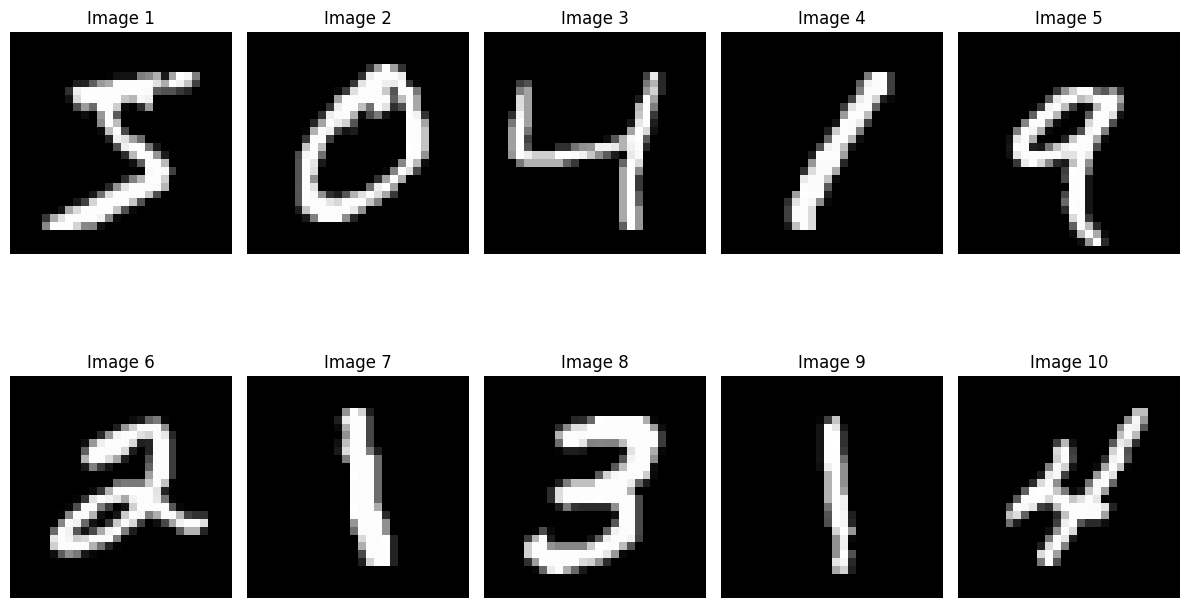

In [187]:
num_images_to_display = 10

plt.figure(figsize=(12, 8))
for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [215]:
def apply_kernel(image, kernel, simulator):

    image_height, image_width = image.shape
    kernel_height, kernel_width = (2,2)
    result = np.zeros((14,14,4))
    for i in range(0,image_height - kernel_height + 1,2):
        for j in range(0,image_width - kernel_width + 1,2):
            P = image[i:i+kernel_height, j:j+kernel_width]
            P = [P[0][0], P[0][1], P[1][0], P[1][1]]
            circuit, keys = kernel.kernel2(P)
            res = simulator.run(circuit, repetitions=10)
            result[i//2][j//2] = [ res.histogram(key=keys[i])[1] * 25.5 for i in range(4)]
            # print(result[i][j])
    # print(result)
    return result


kernel = Kernel()
kernel.update_weight([255,255,255,255])
simulator = cirq.Simulator()
processed_image = apply_kernel(train_images[0], kernel, simulator)
print(processed_image.shape)

(14, 14, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


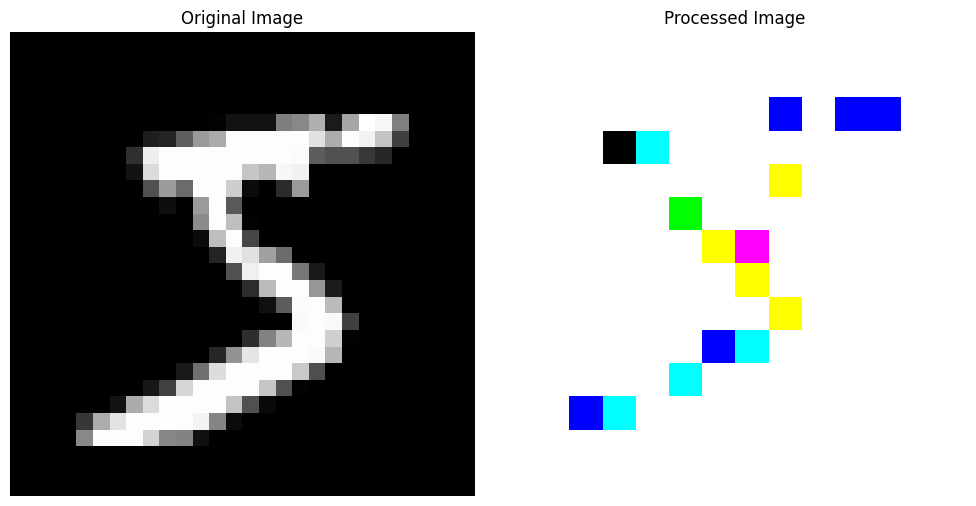

In [216]:
# Display the original and processed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(train_images[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title("Processed Image")
plt.axis('off')

plt.tight_layout()
plt.show()

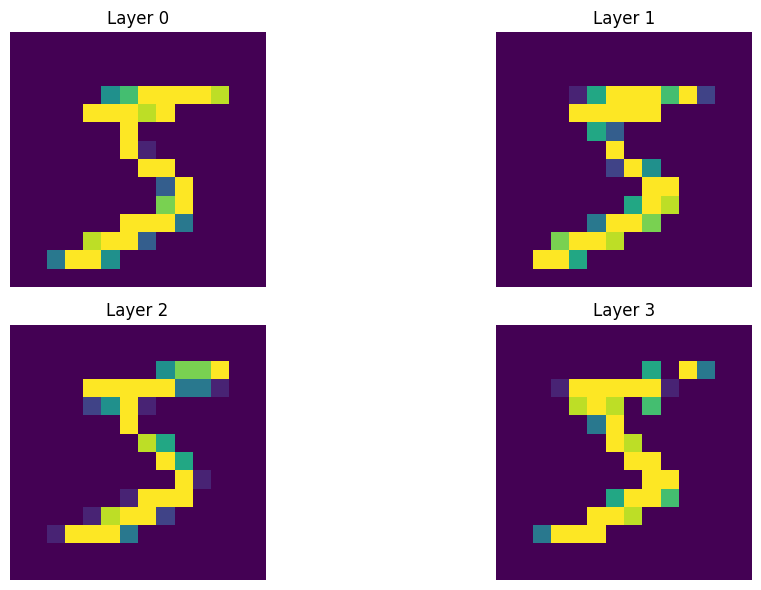

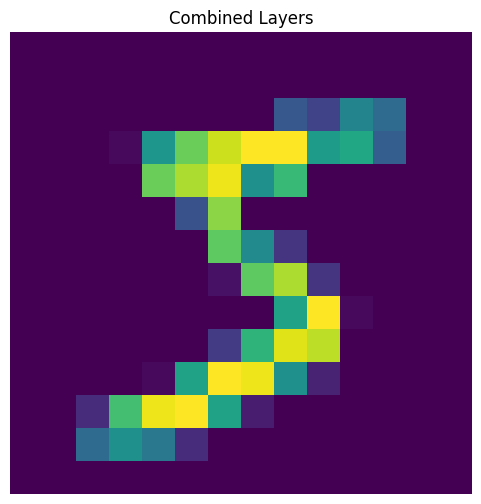

In [217]:
# Generate some example data
image_shape = processed_image.shape
image_data = processed_image

# Visualize individual layers
num_layers = image_shape[-1]
plt.figure(figsize=(12, 6))
for i in range(num_layers):
    plt.subplot(2, num_layers // 2, i + 1)
    plt.imshow(image_data[:, :, i], cmap='viridis')
    plt.title(f'Layer {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Combine layers
combined_image = np.sum(image_data, axis=-1)  # Sum the channels for visualization
plt.figure(figsize=(6, 6))
plt.imshow(combined_image, cmap='viridis')
plt.title('Combined Layers')
plt.axis('off')
plt.show()